In [1]:
import sys

sys.path.append('../..')
sys.path

['/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python39.zip',
 '/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9',
 '/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/lib-dynload',
 '',
 '/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/site-packages',
 '../..']

In [51]:
import tensorflow as tf
from phmd import datasets
import numpy as np
from phm_framework.nets import meta
from phm_framework.nets.dpm  import DiffusionModel
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.cluster import KMeans
from tslearn.metrics import dtw
from scipy.signal import correlate
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema


In [3]:
ds = datasets.Dataset("CWRU")
task = ds['fault']
sets = task[0]

Dataset CWRU already downloaded and extracted
Remember to cite the original publisher dataset:
	@misc{caseBearingData,
		author = {},
		title = {{B}earing {D}ata {C}enter | {C}ase {S}chool of {E}ngineering | {C}ase {W}estern {R}eserve {U}niversity --- engineering.case.edu},
		howpublished = {\url{https://engineering.case.edu/bearingdatacenter}},
		year = {},
		note = {[Accessed 08-04-2024]},
	}
You can download the dataset manually from:  https://engineering.case.edu/bearingdatacenter

** If you find this tool useful, please cite our SoftwareX paper.



Reading data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:12<00:00, 13.16it/s]
INFO:root:Read in 21.47786235809326 seconds
INFO:root:It is possible stratified split? True
/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: unit,fault,DE
INFO:root:Train shape: (28567988, 3)
INFO:root:Val shape: (7804030, 3)
INFO:root:Test shape: (979629, 3)


In [4]:
def extraer_envolventes(serie_temporal, tiempo=None):
    """
    Extrae las envolventes superior e inferior de una serie temporal.

    Args:
        serie_temporal (numpy.ndarray): Serie temporal (1D).
        tiempo (numpy.ndarray, opcional): Tiempos asociados a la serie. Si no se especifica, se usa un índice lineal.

    Returns:
        tuple: (envolvente_superior, envolvente_inferior)
    """
    if tiempo is None:
        tiempo = np.arange(len(serie_temporal))
    
    # Encontrar picos máximos (envolvente superior)
    picos_superior, _ = find_peaks(serie_temporal)
    # Encontrar picos mínimos (envolvente inferior)
    picos_inferior, _ = find_peaks(-serie_temporal)
    
    # Interpolación para generar las envolventes
    interp_superior = interp1d(tiempo[picos_superior], serie_temporal[picos_superior], 
                               kind="linear", bounds_error=False, fill_value="extrapolate")
    interp_inferior = interp1d(tiempo[picos_inferior], serie_temporal[picos_inferior], 
                               kind="linear", bounds_error=False, fill_value="extrapolate")
    
    envolvente_superior = interp_superior(tiempo)
    envolvente_inferior = interp_inferior(tiempo)
    
    return envolvente_superior, envolvente_inferior

def ajustar_pendiente_y_escalar(serie_temporal, pendiente_objetivo, tiempo=None):
    """
    Ajusta una serie temporal para que su pendiente de regresión sea la indicada,
    y escala los valores para que los máximos y mínimos coincidan con la serie original.

    Args:
        serie_temporal (numpy.ndarray): Serie temporal original (1D).
        pendiente_objetivo (float): Pendiente deseada para la línea de regresión.
        tiempo (numpy.ndarray, opcional): Tiempos asociados a la serie. Si no se especifica, se usará un índice lineal.

    Returns:
        numpy.ndarray: Serie temporal ajustada y escalada.
    """
    # Generar tiempo si no está dado
    if tiempo is None:
        tiempo = np.arange(len(serie_temporal))
    
    # Calcular la pendiente actual usando regresión lineal
    tiempo = tiempo.reshape(-1, 1)
    reg = LinearRegression()
    reg.fit(tiempo, serie_temporal)
    pendiente_actual = reg.coef_[0]
    
    # Calcular el ajuste necesario
    ajuste_pendiente = pendiente_objetivo - pendiente_actual
    
    # Modificar la serie para lograr la pendiente deseada
    serie_ajustada = serie_temporal + ajuste_pendiente * (tiempo.flatten() - tiempo.mean())
    
    # Escalar la serie ajustada para que sus máximos y mínimos coincidan con los originales
    min_original, max_original = serie_temporal.min(), serie_temporal.max()
    min_ajustada, max_ajustada = serie_ajustada.min(), serie_ajustada.max()
    
    # Escalamiento lineal
    serie_escalada = ((serie_ajustada - min_ajustada) / (max_ajustada - min_ajustada)) * (max_original - min_original) + min_original
    
    return serie_escalada



def prepare_data(X, signal_col, subsignal_length = 1000, signal_max_length = 20000):

    units_array = X.unit.values
    signal_array = X[signal_col].values
    targets = X[['unit','fault']].drop_duplicates().set_index('unit').fault.to_dict()

    N = signal_max_length // subsignal_length
    X = np.zeros((N*len(targets.keys()), subsignal_length))
    Y = np.zeros((N*len(targets.keys()), 0)) 

    NN = 0
    for i, unit in enumerate(targets.keys()):
        mask = units_array == unit
        signal = signal_array[mask]

        sml = (signal.shape[0] // subsignal_length) * subsignal_length
        n = min(sml // subsignal_length, N)
        sml = subsignal_length * n
        signal = signal[:sml]
        signal = signal.reshape((n, subsignal_length))

        X[NN:NN+n] = signal
        Y[NN:NN+n] = targets[unit]

        NN += n

    
    X = X[:NN]
    _xmin, _xmax = X.min(axis=1), X.max(axis=1)
    X = ((X.T - _xmin) / (_xmax - _xmin)).T    
    
    Y = X[:NN]
    
    M = meta.get_attributes(X, n_jobs=8)
    

    return X, M, Y

In [5]:
X_train, M_train, Y_train = prepare_data(sets['train'], 'DE', subsignal_length=128, signal_max_length=20000)
#_xmin, _xmax = X_train.min(axis=1), X_train.max(axis=1)
_mmin, _mmax = M_train.min(axis=0), M_train.max(axis=0)

#X_train = ((X_train.T - _xmin) / (_xmax - _xmin)).T
#M_train = (M_train - _mmin) / (_mmax - _mmin)

X_val, M_val, Y_val = prepare_data(sets['val'], 'DE', subsignal_length=128, signal_max_length=20000)

#_xmin, _xmax = X_val.min(axis=1), X_val.max(axis=1)
#X_val = ((X_val.T - _xmin) / (_xmax - _xmin)).T
#M_val = (M_val - _mmin) / (_mmax - _mmin)


INFO:root:Meta-attributes extracted in 39.69974637031555 seconds
INFO:root:Meta-attributes extracted in 10.884983777999878 seconds


In [11]:
def sbd(x, y):
    """
    Shape-Based Distance (SBD) entre dos series temporales.
    Se basa en la normalización de la correlación cruzada.
    """
    # Correlación cruzada normalizada
    correlation = correlate(x - np.mean(x), y - np.mean(y), mode='full')
    correlation = correlation / (np.linalg.norm(x) * np.linalg.norm(y))
    
    # La SBD es 1 menos la máxima correlación
    return 1 - np.max(correlation)

def dtw_distance_matrix(X):
    """
    Calcula la matriz de distancias utilizando DTW (Dynamic Time Warping).
    """
    n = len(X)
    dist_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):
            dist_matrix[i, j] = dist_matrix[j, i] = dtw(X[i], X[j])  # Usando DTW de tslearn
    return dist_matrix

def sbd_distance_matrix(X):
    """
    Calcula la matriz de distancias utilizando Shape-Based Distance (SBD).
    """
    n = len(X)
    dist_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):
            dist_matrix[i, j] = dist_matrix[j, i] = sbd(X[i], X[j])  # Usando SBD
    return dist_matrix

def calculate_centroids(X, labels, n_clusters, metric='dtw'):
    """
    Calcula los centroides de los clusters utilizando la métrica personalizada.
    
    Args:
        X (numpy.ndarray): Matriz de series temporales (n_series x n_timestamps).
        labels (numpy.ndarray): Etiquetas de los clusters.
        n_clusters (int): Número de clusters.
        metric (str): La métrica a usar ('dtw' o 'sbd').
    
    Returns:
        centroids (list): Una lista de los centroides de los clusters.
    """
    centroids = []
    for i in range(n_clusters):
        # Seleccionamos las series pertenecientes al cluster i
        cluster_series = X[labels == i]
        
        centroids.append(cluster_series.mean(axis=0))
    
    return np.array(centroids)

def clusterizar_series_temporales(series_temporales, n_clusters=3, metric='dtw'):
    """
    Realiza el clustering de series temporales usando KMeans y una métrica personalizada (DTW o SBD).
    
    Args:
        series_temporales (numpy.ndarray): Matriz de series temporales (n_series x n_timestamps).
        n_clusters (int): Número de clusters a formar.
        metric (str): La métrica a usar ('dtw' o 'sbd').
    
    Returns:
        labels (numpy.ndarray): Etiquetas de los clusters asignadas a cada serie temporal.
        centroids (numpy.ndarray): Los centroides de los clusters.
    """
    # Calcular la matriz de distancias según la métrica seleccionada
    if metric == 'dtw':
        dist_matrix = dtw_distance_matrix(series_temporales)
    elif metric == 'sbd':
        dist_matrix = sbd_distance_matrix(series_temporales)
    else:
        raise ValueError("Métrica no soportada. Usa 'dtw' o 'sbd'.")
    
    # Aplicar KMeans sobre la matriz de distancias
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(dist_matrix)
    
    # Obtener etiquetas de los clusters
    labels = kmeans.labels_
    
    # Calcular los centroides
    centroids = calculate_centroids(series_temporales, labels, n_clusters, metric)
    
    return labels, centroids

def plot_clusters(series_temporales, labels, centroids, n_clusters):
    """
    Dibuja los clusters con una cuadrícula de 3 columnas y N filas.

    Args:
        series_temporales (numpy.ndarray): Array de series temporales.
        labels (numpy.ndarray): Etiquetas de los clusters.
        centroids (numpy.ndarray): Centroides de los clusters.
        n_clusters (int): Número de clusters.
    """
    # Determinar el número de filas y columnas
    n_cols = 3
    n_rows = int(np.ceil(n_clusters / n_cols))

    plt.figure(figsize=(15, n_rows * 5))  # Ajustar tamaño según filas

    for cluster_idx in range(n_clusters):
        plt.subplot(n_rows, n_cols, cluster_idx + 1)  # Configurar subplot
        #for i, series in enumerate(series_temporales):
        #    if labels[i] == cluster_idx:
        #        if len(series.shape) > 2:
        #            plt.plot(series[0, :], alpha=0.6, label=f"Serie {i}")
        #            plt.plot(series[1, :], alpha=0.6, label=f"Serie {i}")
        #        else:
        #            plt.plot(series, alpha=0.6, label=f"Serie {i}")
        #plt.plot(centroids[cluster_idx].ravel(), color="black", linewidth=2, label="Centroide")
        plt.plot(centroids[cluster_idx, 0, :])
        plt.plot(centroids[cluster_idx, 1, :])
        plt.title(f"Cluster {cluster_idx}")
        plt.ylim(0, 1)
        plt.legend(loc="upper right")
        plt.grid(True)

    plt.tight_layout()
    plt.show()



/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


finalizado


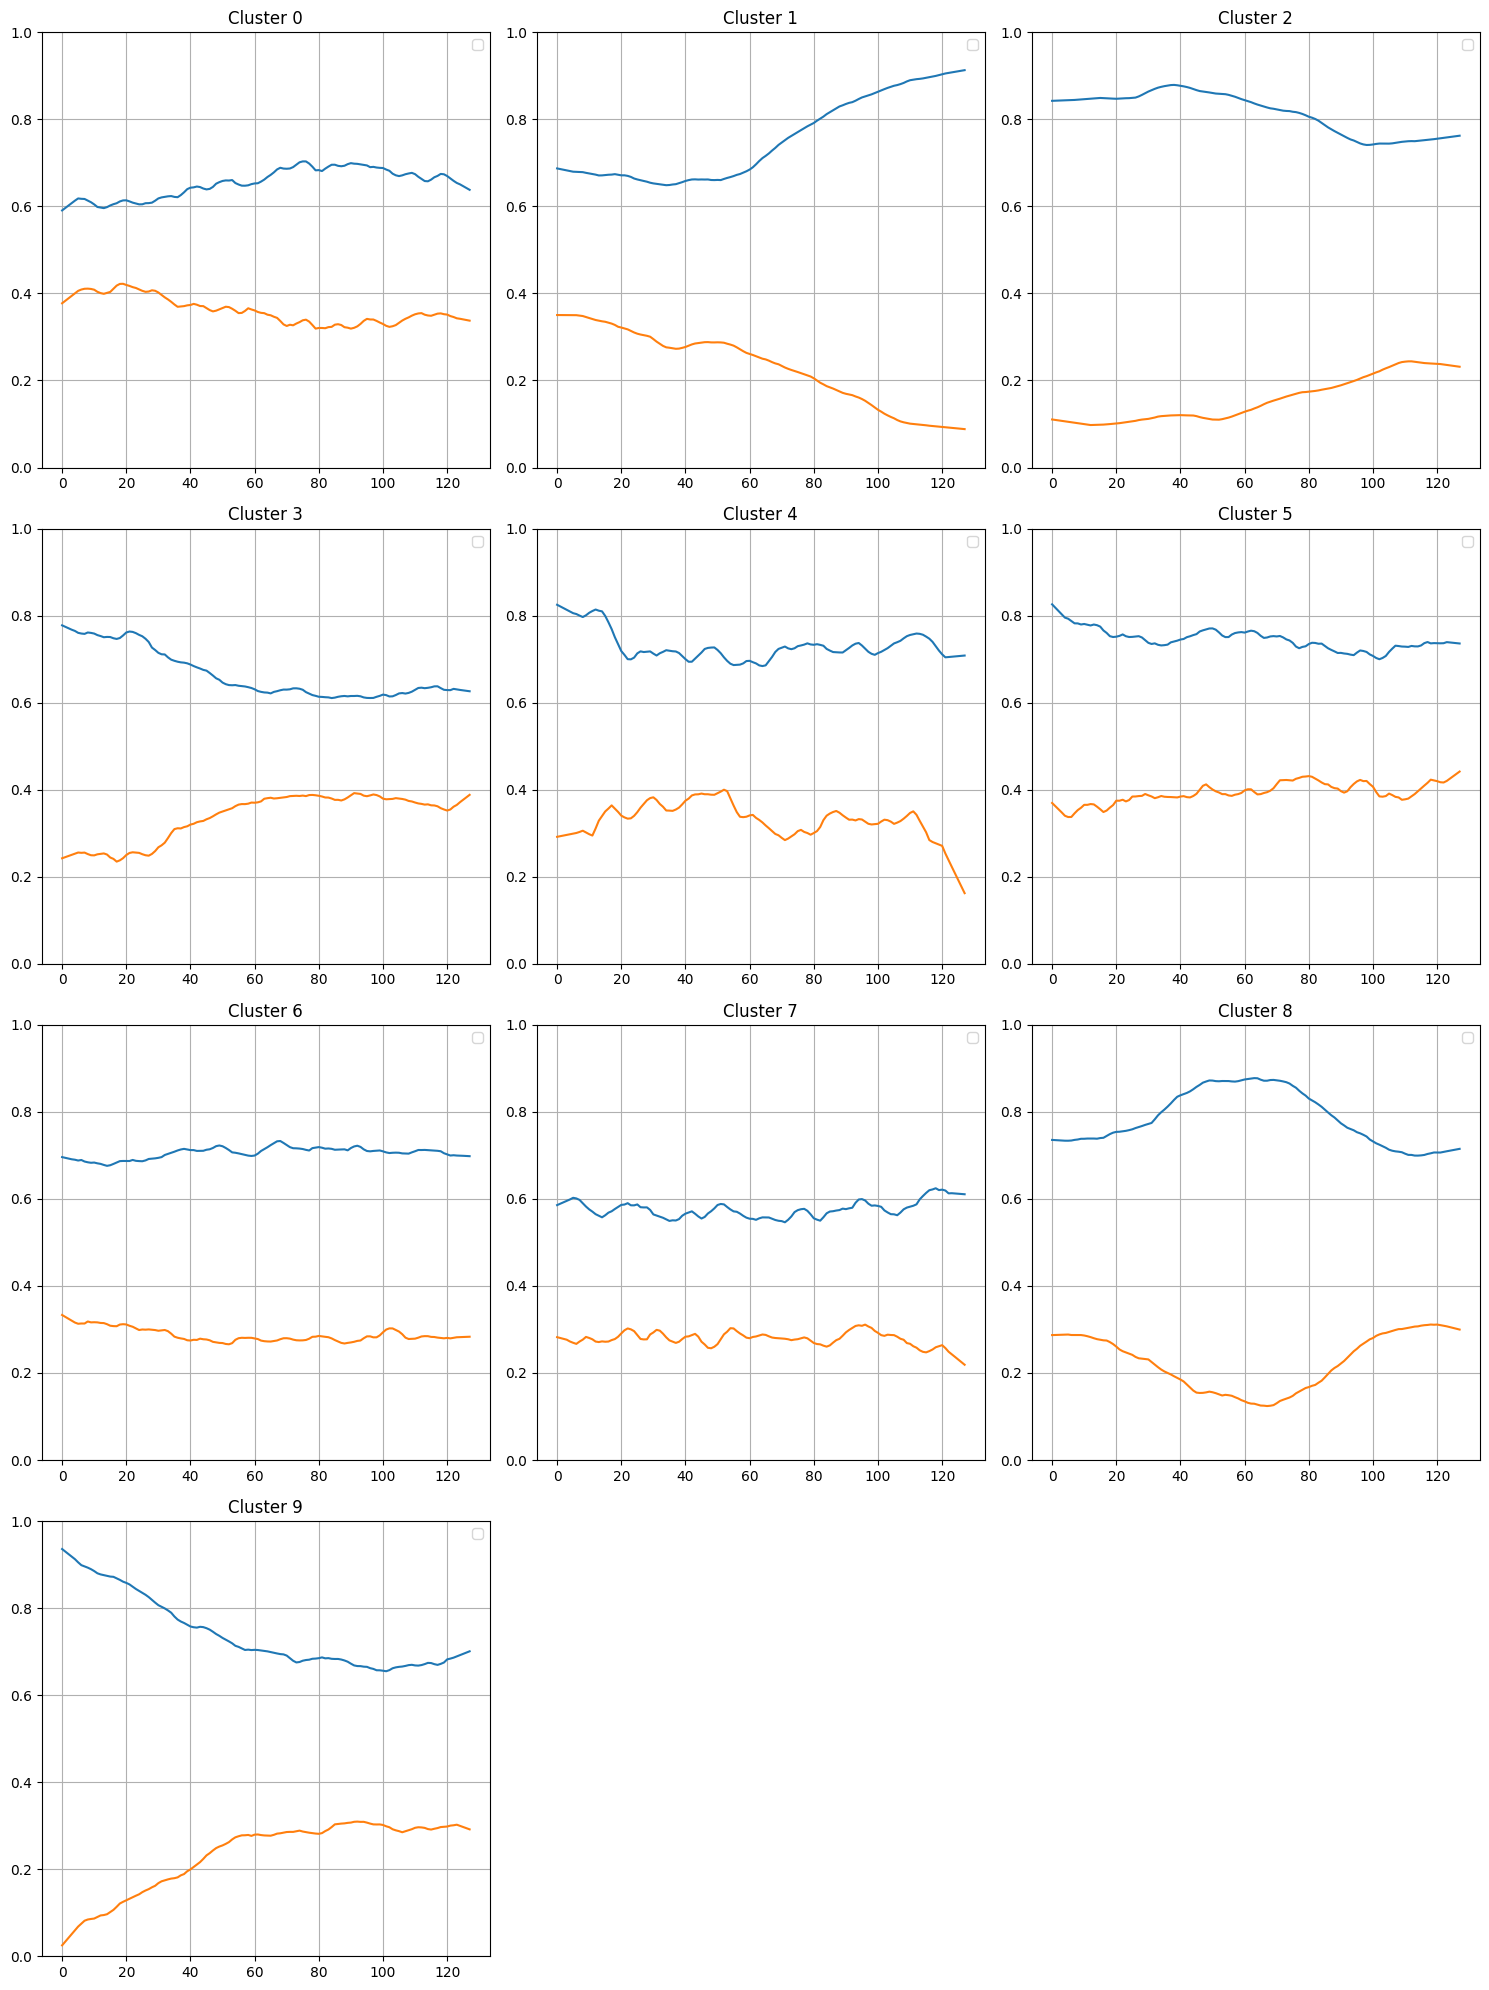

In [12]:
# Generar series temporales aleatorias
N  = 1000
indexes = np.arange(1, X_train.shape[0])
np.random.shuffle(indexes)
envolventes  = [extraer_envolventes(X_train[indexes[i]]) for i in range(N)]
series_temporales = np.abs(np.array(envolventes)[:N, 0] -  np.array(envolventes)[:N, 1])
series_temporales = np.array(envolventes)[:N, 0]

series_temporales = np.array(envolventes)[:N, :, :]


# Aplicar clustering con K-means y DTW
n_clusters = 10
labels, centroids = clusterizar_series_temporales(series_temporales, n_clusters, metric='dtw')
print("finalizado")
# Dibujar clusters
plot_clusters(series_temporales, labels, centroids, n_clusters)

In [110]:
def ajustar_a_envolventes_preservando_forma(señal_original, envolvente_superior, envolvente_inferior):
    """
    Ajusta una señal para que sus máximos y mínimos locales coincidan exactamente con las envolventes,
    preservando la forma original de la señal.

    Args:
        señal_original (numpy.ndarray): Señal original (1D).
        envolvente_superior (numpy.ndarray): Envolvente superior (1D).
        envolvente_inferior (numpy.ndarray): Envolvente inferior (1D).

    Returns:
        numpy.ndarray: Señal ajustada respetando las envolventes y preservando la forma.
    """
    # Verificar que las envolventes tengan el mismo tamaño que la señal original
    if len(señal_original) != len(envolvente_superior) or len(señal_original) != len(envolvente_inferior):
        raise ValueError("Las envolventes y la señal original deben tener el mismo tamaño.")
    
    # Detectar máximos y mínimos locales
    maximos_locales = argrelextrema(señal_original, np.greater)[0]
    minimos_locales = argrelextrema(señal_original, np.less)[0]
    puntos_extremos = np.sort(np.concatenate([[0, len(señal_original)-1], maximos_locales, minimos_locales]))
    print(puntos_extremos)
    
    # Inicializar la señal ajustada
    señal_ajustada = np.copy(señal_original)
    
    # Ajustar cada segmento entre extremos
    for i in range(len(puntos_extremos) - 1):
        inicio = puntos_extremos[i]
        fin = puntos_extremos[i + 1]
        
        # Valores originales y target en los extremos
        valor_inicio = señal_original[inicio]
        valor_fin = señal_original[fin]
        
        if valor_inicio > valor_fin:  # Máximo seguido de mínimo
            target_inicio = envolvente_superior[inicio] if inicio != 0 else señal_original[0]
            target_fin = envolvente_inferior[fin] if fin != len(señal_original) -1 else señal_original[-1]
        else:  # Mínimo seguido de máximo
            target_inicio = envolvente_inferior[inicio] if inicio != 0 else señal_original[0]
            target_fin = envolvente_superior[fin] if fin != len(señal_original) -1 else señal_original[-1]
        
        # Escalar el segmento para que los extremos coincidan con las envolventes
        segmento_original = señal_original[inicio:fin + 1]
        segmento_ajustado = (segmento_original - valor_inicio) / (valor_fin - valor_inicio)  # Normalizar
        segmento_ajustado = segmento_ajustado * (target_fin - target_inicio) + target_inicio  # Escalar
        
        # Actualizar la señal ajustada
        señal_ajustada[inicio:fin + 1] = segmento_ajustado
    
    return señal_ajustada



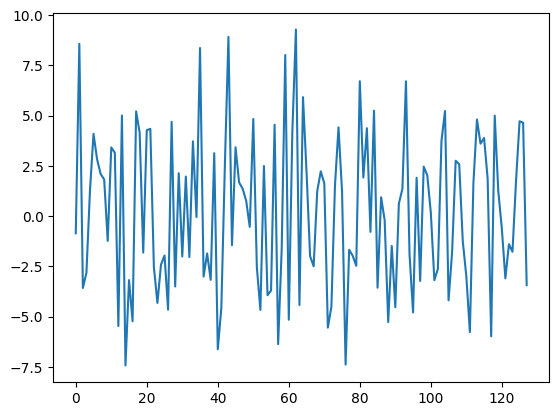

In [101]:
N = 10000
time = np.linspace(0, 10, 128)
frec1 = np.random.uniform(0.1, 1, N) * np.pi
frec2 = np.random.uniform(0.1, 1, N) * np.pi
pend = np.random.uniform(-0.1, 0.1, N) 
noise = np.random.uniform(0, 1, N) 

frencuencias = [np.random.uniform(0.1, 1, N) * np.pi for _ in range(10)]
X_sin = np.array([time] * N)

for i in range(N):
    s = np.zeros((128,))
    for f in frencuencias:
        s += np.sin(X_sin[i] * 2 * f[i]) 
        s = s + np.random.normal(size=s.shape) * noise[i]
        X_sin[i] = s

plt.plot(X_sin[4])

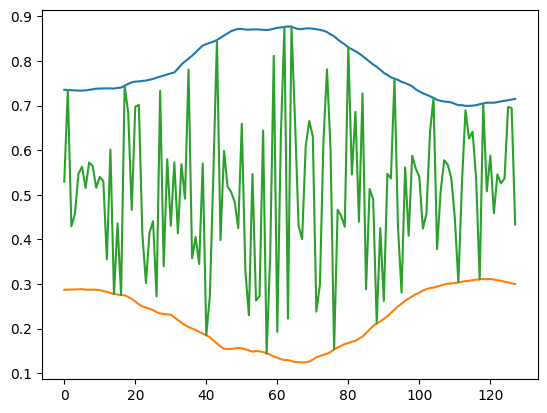

In [123]:
def ajustar_a_envolventes_preservando_forma(señal_original, envolvente_superior, envolvente_inferior):
    """
    Ajusta una señal para que sus máximos y mínimos locales coincidan exactamente con las envolventes,
    preservando la forma original de la señal.

    Args:
        señal_original (numpy.ndarray): Señal original (1D).
        envolvente_superior (numpy.ndarray): Envolvente superior (1D).
        envolvente_inferior (numpy.ndarray): Envolvente inferior (1D).

    Returns:
        numpy.ndarray: Señal ajustada respetando las envolventes y preservando la forma.
    """
    # Verificar que las envolventes tengan el mismo tamaño que la señal original
    if len(señal_original) != len(envolvente_superior) or len(señal_original) != len(envolvente_inferior):
        raise ValueError("Las envolventes y la señal original deben tener el mismo tamaño.")

    step = 16
    señal_ajustada = np.copy(señal_original)
    for i in np.arange(0, señal_ajustada.shape[0], step): 
        _min, _max = señal_ajustada[i:i+step].min(), señal_ajustada[i:i+step].max()
        
        señal_ajustada[i:i+step] = (señal_ajustada[i:i+step] - _min) / (_max - _min)
    señal_ajustada_scaled = np.copy(señal_ajustada)

    _emin, _emax = envolvente_inferior.min(), envolvente_superior.max()

    factor = 1 / (_emax - _emin)
    envolvente_inferior = (envolvente_inferior - _emin) * factor
    
    envolvente_superior = (envolvente_superior - _emin) * factor

    indexes = np.where(señal_ajustada >= 0.5)
    señal_ajustada[indexes] = señal_ajustada[indexes] * envolvente_superior[indexes]

    indexes = np.where(señal_ajustada < 0.5)
    señal_ajustada[indexes] = 1 - ((1 - señal_ajustada[indexes]) * (1- envolvente_inferior[indexes]))

    
    señal_ajustada = (señal_ajustada / factor) + _emin
    
    return señal_ajustada, señal_ajustada_scaled



e = 8
s = 4
s, se = ajustar_a_envolventes_preservando_forma(X_sin[s],  centroids[e][0], centroids[e][1])
#plt.plot(centroids[e][0])
plt.plot(centroids[e][1])
plt.plot(s)
#plt.plot(se)
